In [932]:
from xopen import xopen
import glob
import json
import pandas as pd
import numpy as np
import datetime

files = glob.glob("birkenstock/2*xz")
content = ""
counter = 1


for file in files:
    with xopen(file) as f:
        if counter == 1:
            content = content + "[" + str(f.read()) + ", \n"
            counter += 1
        elif counter == len(files):
            content = content + str(f.read()) + "]"
            counter += 1
        else:
            content = content + str(f.read()) + ", \n"
            counter += 1

data = json.loads(content)
brand = file[:file.find('\\')]

In [933]:
list_item = []
list_header = ['description', 'date_posted', 'id', 'likes', 'comments', 'is_video']

for data in data:
    list_item += [([i.lower() for i in (data['node']['edge_media_to_caption']['edges'][0]['node']['text']).split() if i[0] == '#'],
                datetime.datetime.fromtimestamp(data['node']['taken_at_timestamp']).strftime('%Y-%m-%d %H:%M:%S'),
                data['node']['id'],
                data['node']['edge_media_preview_like']['count'],
                data['node']['edge_media_to_comment']['count'],
                data['node']['is_video'])]
    

In [934]:
df_page = pd.DataFrame((list_item), columns = list_header)

df_page['date_posted'] = df_page['date_posted'].astype('datetime64[ns]')
df_page['id'] = df_page['id'].astype('int64')

df_page['day'] = df_page['date_posted'].dt.day_name()

In [935]:
hashtags = df_page.apply(lambda x: pd.Series(x['description']),axis=1).stack().reset_index(level=1, drop=True)
            
hashtags.name = 'hashtag'

df_page = df_page.drop('description', axis = 1).join(hashtags)

In [936]:
%matplotlib inline

Text(0,0.5,'Total number of Instagram posts')

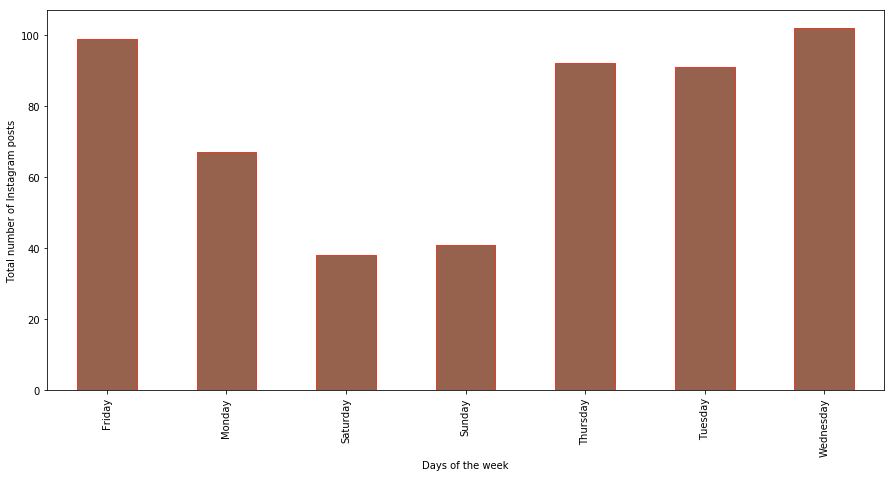

In [937]:
plt.figure(figsize=(15,7))
df_distinct = df_page.groupby(['id', 'day']).count()
df_distinct.groupby(['day']).count()['hashtag'].plot(kind = 'bar', color="#96624E", edgecolor = '#E13F29')
plt.xlabel('Days of the week')
plt.ylabel('Total number of Instagram posts')

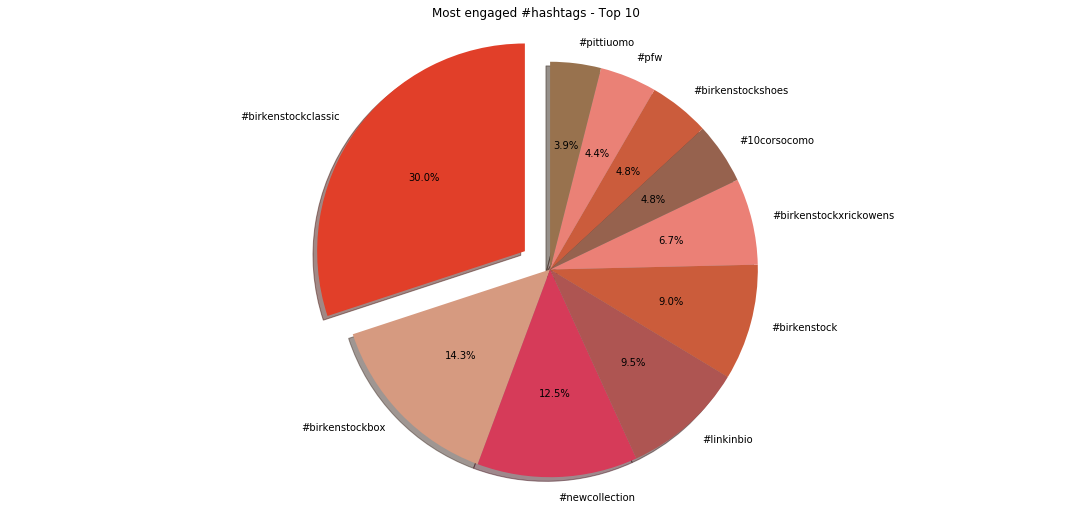

In [938]:
top10_hashtag = df_page.groupby(['hashtag']).count()['day'].reset_index(name='count').sort_values(['count'], ascending=False).head(n=10)
plt.figure(figsize = (15, 7))
explode = (0.15, 0, 0, 0, 0, 0, 0, 0, 0, 0)
colors = ["#E13F29", "#D69A80", "#D63B59", "#AE5552", "#CB5C3B", "#EB8076", "#96624E", "#CB5C3C", "#EA8176", "#98724E"]
plt.pie(top10_hashtag['count'], labels = top10_hashtag['hashtag'], startangle=90, colors = colors, shadow = True, explode = explode, autopct='%1.1f%%')
plt.axis('equal')
plt.tight_layout()
plt.title('Most engaged #hashtags - Top 10')
plt.show()

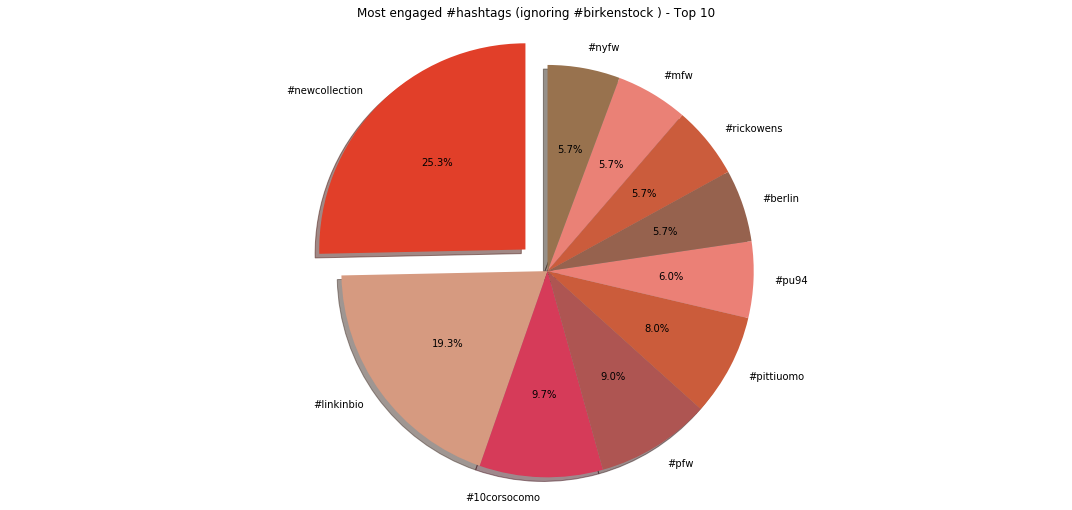

In [939]:
top10_hashtag_nb = df_page.groupby(['hashtag']).count()['day'].reset_index(name='count').sort_values(['count'], ascending=False)
top10_hashtag_nb = top10_hashtag_nb[~top10_hashtag_nb['hashtag'].str.contains(brand)].head(10)
plt.figure(figsize = (15, 7))
explode = (0.15, 0, 0, 0, 0, 0, 0, 0, 0, 0)
colors = ["#E13F29", "#D69A80", "#D63B59", "#AE5552", "#CB5C3B", "#EB8076", "#96624E", "#CB5C3C", "#EA8176", "#98724E"]
plt.pie(top10_hashtag_nb['count'], labels = top10_hashtag_nb['hashtag'], startangle=90, colors = colors, shadow = True, explode = explode, autopct='%1.1f%%')
plt.axis('equal')
plt.tight_layout()
plt.title('Most engaged #hashtags (ignoring #'+ brand +' ) - Top 10')
plt.show()

Text(0.5,1,'Sum of comments on all posts')

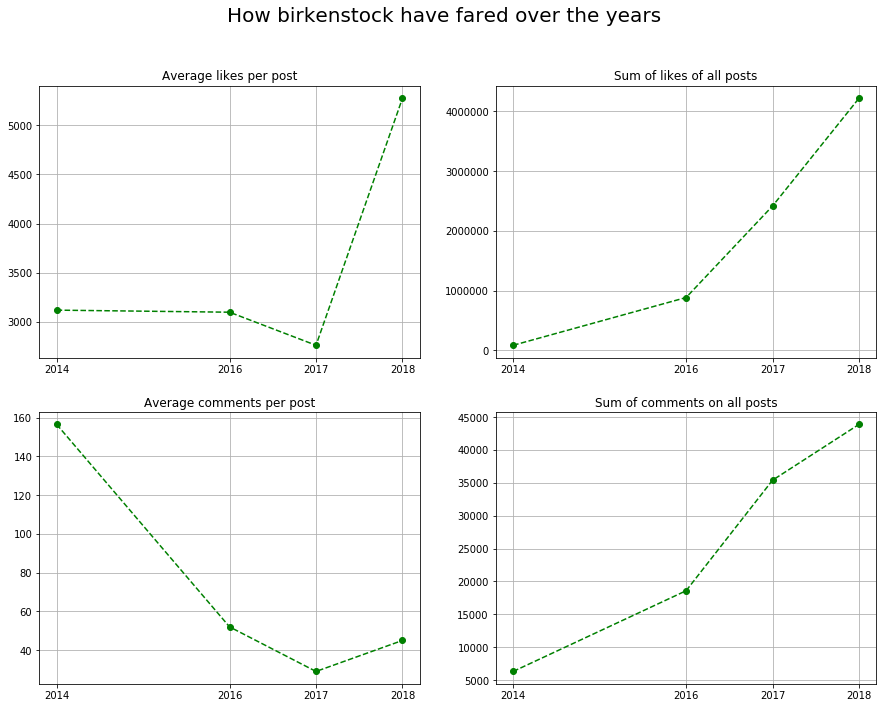

In [940]:
df_page.sort_values(['date_posted'], ascending = False)

plt.figure(figsize = (15, 11))
plt.suptitle('How ' + brand + ' have fared over the years', fontsize = 20)

plt.subplot(221)
year_grp = df_page.groupby([(df_page.date_posted.dt.year)]).likes.median()
plt.plot(year_grp, 'go--')
plt.grid()
plt.xticks(df_page.date_posted.dt.year.unique())
plt.title('Average likes per post')

plt.subplot(222)
year_grp = df_page.groupby([(df_page.date_posted.dt.year)]).likes.sum()
plt.plot(year_grp, 'go--')
plt.grid()
plt.xticks(df_page.date_posted.dt.year.unique())
plt.title('Sum of likes of all posts')

plt.subplot(223)
year_grp = df_page.groupby([(df_page.date_posted.dt.year)]).comments.median()
plt.plot(year_grp, 'go--')
plt.grid()
plt.xticks(df_page.date_posted.dt.year.unique())
plt.title('Average comments per post')

plt.subplot(224)
year_grp = df_page.groupby([(df_page.date_posted.dt.year)]).comments.sum()
plt.plot(year_grp, 'go--')
plt.grid()
plt.xticks(df_page.date_posted.dt.year.unique())
plt.title('Sum of comments on all posts')

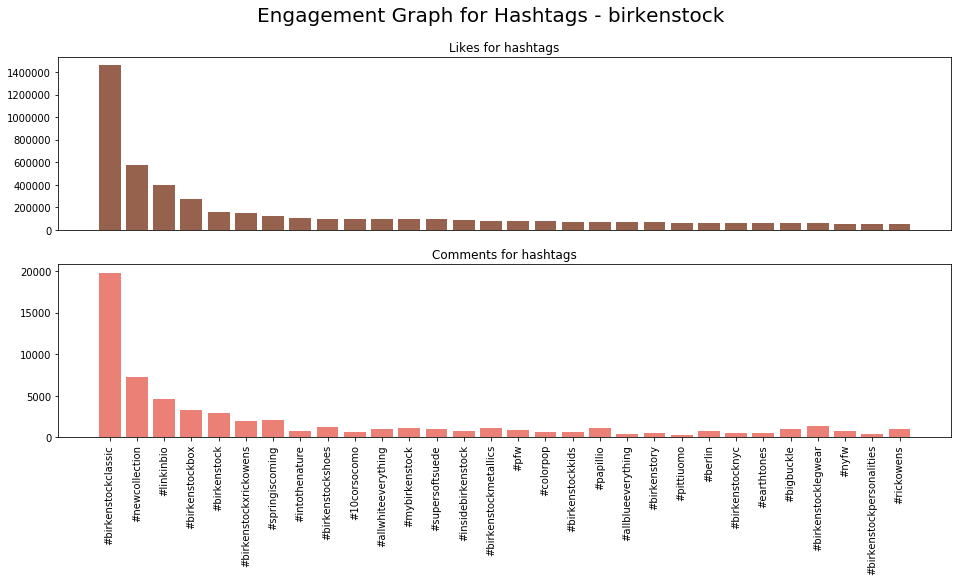

In [941]:
df_engagement = df_page.groupby(['hashtag']).sum().sort_values(['likes'], ascending=False)[['likes', 'comments']].head(30)


plt.figure(figsize=(16, 7))
plt.suptitle('Engagement Graph for Hashtags - ' + brand, fontsize = 20)

plt.subplot(211)
plt.bar(df_engagement.index, df_engagement['likes'], color = "#96624E")
plt.xticks([])
plt.title('Likes for hashtags')


plt.subplot(212)
plt.bar(df_engagement.index, df_engagement['comments'], color = "#EB8076")
plt.xticks(rotation='vertical')
plt.title('Comments for hashtags')
plt.show()